<a href="https://colab.research.google.com/github/amanzoni1/DL_ImageSegmentation/blob/main/U%5E2NetSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation
## Project Overview

In the realm of computer vision, instance segmentation is a critical task with applications ranging from autonomous driving to augmented reality. Our project focuses on developing a sophisticated image processing pipeline that can segment people from images and seamlessly replace the background with various cities or tourist spots. This not only enhances visual aesthetics but also has potential applications in photography, virtual backgrounds for video conferencing, and creative media.

We will leverage the **COCO (Common Objects in Context) dataset**, specifically focusing on the ‘person’ category. By utilizing a **U^2-Net (U-square Net) model**, we’ll perform precise segmentation of individuals in images. The project aims to deliver high-quality results suitable for practical use.

## Key Objectives

1. **Develop and Train a Neural Network Model:**
   - Utilize a pre-trained U^2-Net model and fine-tune it for our specific task.

2. **Implement Instance Segmentation:**
   - Accurately segment people from images using advanced deep learning techniques.

3. **Background Replacement:**
   - Replace the original background with selected images of cities or tourist spots while maintaining the integrity of the foreground subject.

4. **Utilize the COCO Dataset:**
   - Work with a substantial subset of the COCO dataset containing images of people to train and validate our model effectively.



## Dataset

**COCO (Common Objects in Context) Dataset:**

- **Description:** A large-scale object detection, segmentation, and captioning dataset with over 200,000 images and 80 object categories.
- **Usage in Project:** We’ll focus on images containing the ‘person’ category. A subset of 64,000 images has been downloaded and stored in Google Drive for this project.

## Task

Develop a pipeline that can:

- **Segment individuals** in images with high accuracy.
- **Replace the background** while preserving the foreground subject’s details.
- **Maintain realistic blending** between the foreground and new background.

## Approach

1. **Exploratory Data Analysis (EDA):**
   - Understand the dataset’s structure and contents.
   - Visualize sample images and annotations to gain insights.

2. **Data Preparation:**
   - Implement a custom dataset class to load images and annotations.
   - Apply data transformations and augmentations to enhance model robustness.

3. **Model Setup:**
   - Initialize a pre-trained U^2-Net model.
   - Modify the model to suit our specific segmentation task.

4. **Model Training:**
   - Fine-tune the model using the prepared dataset.
   - Monitor training progress and optimize performance.

5. **Evaluation:**
   - Assess the model’s performance using appropriate metrics.
   - Visualize predictions to qualitatively evaluate segmentation quality.

6. **Background Replacement Pipeline:**
   - Develop functions to replace the background of segmented images.
   - Ensure seamless integration between the foreground and new background.

7. **Interactive Testing:**
   - Create an interface in Colab for users to upload images and select backgrounds.
   - Allow real-time testing of the segmentation and background replacement.

## Implementation

In [ ]:
# 🚀 Install Required Packages
!pip install -q torchinfo torchvision torchaudio torchmetrics pillow pycocotools opencv-python matplotlib pytorch-lightning segmentation-models-pytorch

# 📚 Import Standard Libraries
import os
import numpy as np
import random
import json
import logging

# 🎨 Import Visualization Libraries
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

# 🧠 Import Deep Learning Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, models
import torchvision.transforms.functional as F
import segmentation_models_pytorch as smp

# 🔧 Import Additional Libraries
from google.colab import drive
from IPython.display import display
from pycocotools.coco import COCO

# ⚙️ Set Computational Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


Now, I’m mounting my Google Drive to access the images I’ve already downloaded in the COCO_person_dataset directory. I’ll also download the annotations and save them in the COCO_annotations directory on my Drive, so both images and annotations are stored persistently.

With the annotations available, I initialize the COCO API using the annotations file from my Drive. I retrieve the category IDs and image IDs to explore the dataset, focusing on the ‘person’ category to get all associated image IDs.

Finally, I filter the image IDs to include only the images I’ve downloaded by matching filenames in my dataset directory, ensuring my dataset is properly aligned with the annotations and ready for training.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = '/content/drive/MyDrive/deep_learning/dataset/COCO/COCO_person_dataset'
annotations_dir = '/content/drive/MyDrive/deep_learning/dataset/COCO/COCO_annotations'

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(annotations_dir, exist_ok=True)

In [ ]:
annotations_zip_path = '/content/annotations_trainval2017.zip'
annotations_file = os.path.join(annotations_dir, 'instances_train2017.json')

# Check if annotations already exist in Drive
if not os.path.exists(annotations_file):
    # Download annotations ZIP to Colab's local storage
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O {annotations_zip_path}

    # Unzip the specific annotation file to Google Drive
    !unzip -j {annotations_zip_path} annotations/instances_train2017.json -d {annotations_dir}

    # Remove the ZIP file from Colab's local storage
    os.remove(annotations_zip_path)
else:
    print("Annotations already exist in Google Drive.")

Annotations already exist in Google Drive.


In [ ]:
# Initialize COCO API
coco = COCO(annotations_file)

loading annotations into memory...
Done (t=16.52s)
creating index...
index created!


In [ ]:
# Get all category IDs
cat_ids = coco.getCatIds()

# Get all image IDs
img_ids = coco.getImgIds()

print(f"Number of categories: {len(cat_ids)}")
print(f"Number of images: {len(img_ids)}")

Number of categories: 80
Number of images: 118287


In [ ]:
# Get category ID for 'person'
person_cat_id = coco.getCatIds(catNms=['person'])[0]

# Get all image IDs containing the 'person' category
img_ids = coco.getImgIds(catIds=[person_cat_id])
print(f"Total images with 'person' annotations: {len(img_ids)}")

Total images with 'person' annotations: 64115


In [ ]:
# Get list of image filenames in your dataset directory
downloaded_filenames = set(os.listdir(dataset_dir))

# Create a mapping from filename to image ID for images that exist
filename_to_img_id = {}
for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    filename = img_info['file_name']
    if filename in downloaded_filenames:
        filename_to_img_id[filename] = img_id

# Update img_ids to only include images you have downloaded
img_ids = list(filename_to_img_id.values())
print(f"Number of images available for training: {len(img_ids)}")

Number of images available for training: 64115


### Exploratory Data Analysis (EDA)

In this section, I will perform an exploratory data analysis (EDA) to gain a deeper understanding of our dataset and ensure it is properly prepared for model training. I will start by displaying some sample images along with their annotations—bounding boxes and segmentation masks—to visually confirm that the data is correctly loaded and annotated. Then, I will analyze the distribution of images and annotations by checking how many persons are present in each image, which will help me understand the dataset’s characteristics and how it aligns with our project’s goals. Additionally, I will examine the image sizes to assess the variability in dimensions, which may inform any necessary preprocessing steps. By verifying the segmentation masks and ensuring that the images and annotations are properly aligned, I aim to confirm that our dataset is accurately prepared and suitable for proceeding to the model training phase.


In [ ]:
from matplotlib.patches import Rectangle

def display_image_with_annotations(coco, img_id, dataset_dir):
    # Load image metadata
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(dataset_dir, img_info['file_name'])

    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # Load annotations for the image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.imshow(img_np)
    ax.axis('off')

    # Add bounding boxes and segmentation masks
    for ann in anns:
        # Draw bounding box
        bbox = ann['bbox']
        x_min, y_min, width, height = bbox
        rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Draw segmentation mask (if available)
        if 'segmentation' in ann:
            segmentation = ann['segmentation']
            if isinstance(segmentation, list):
                for seg in segmentation:
                    poly = np.array(seg).reshape((len(seg)//2, 2))
                    patch = plt.Polygon(poly, facecolor='none', edgecolor='green', linewidth=2)
                    ax.add_patch(patch)

    plt.title(f"Image ID: {img_id} with Annotations")
    plt.show()

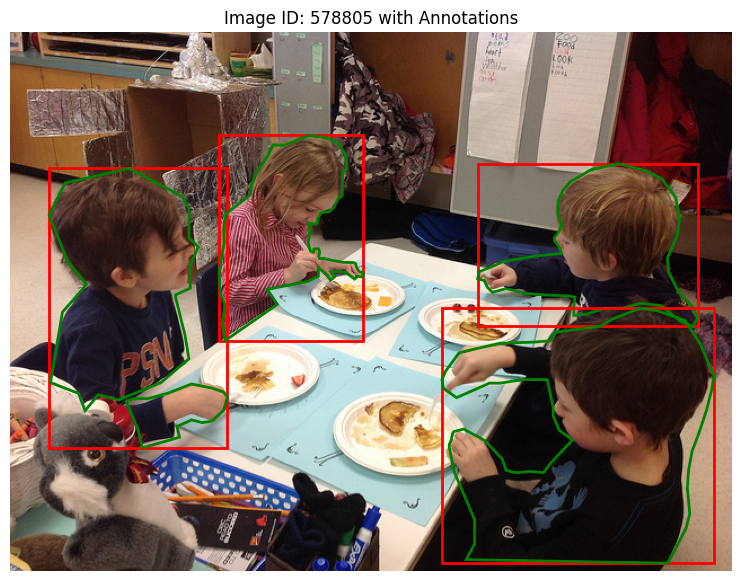

In [ ]:
# Choose a random image ID from the available IDs
sample_img_id = random.choice(img_ids)

# Display the image with annotations
display_image_with_annotations(coco, sample_img_id, dataset_dir)

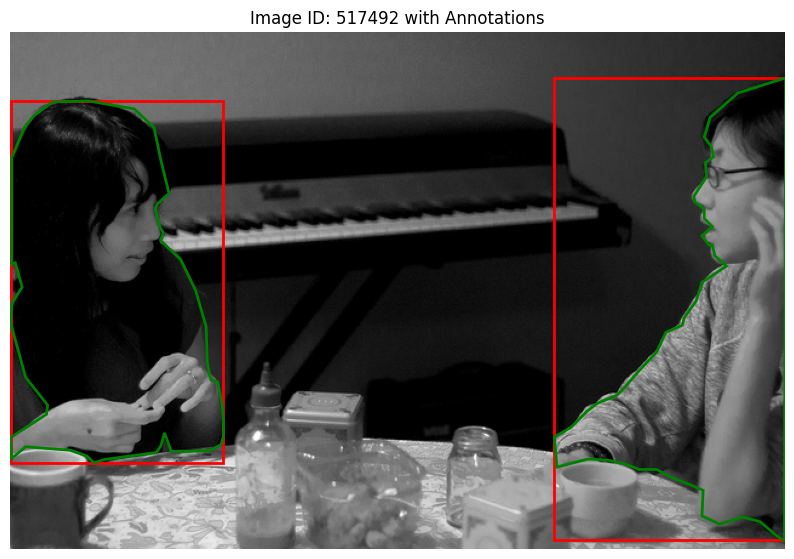

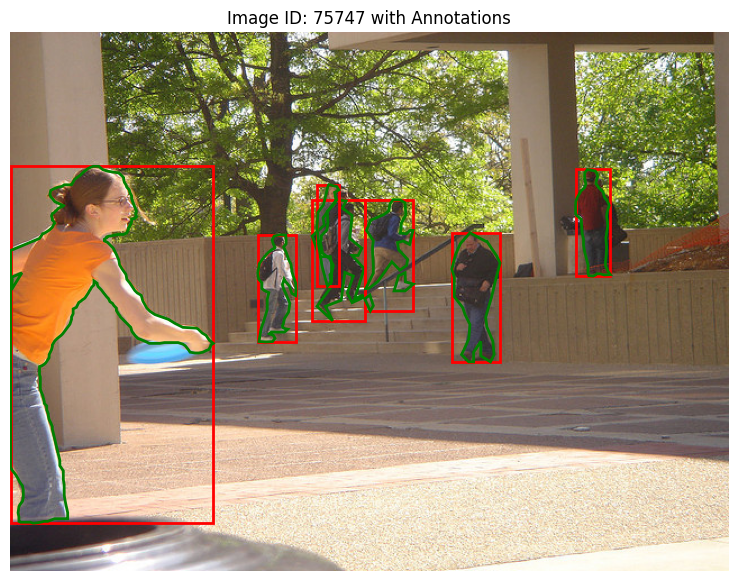

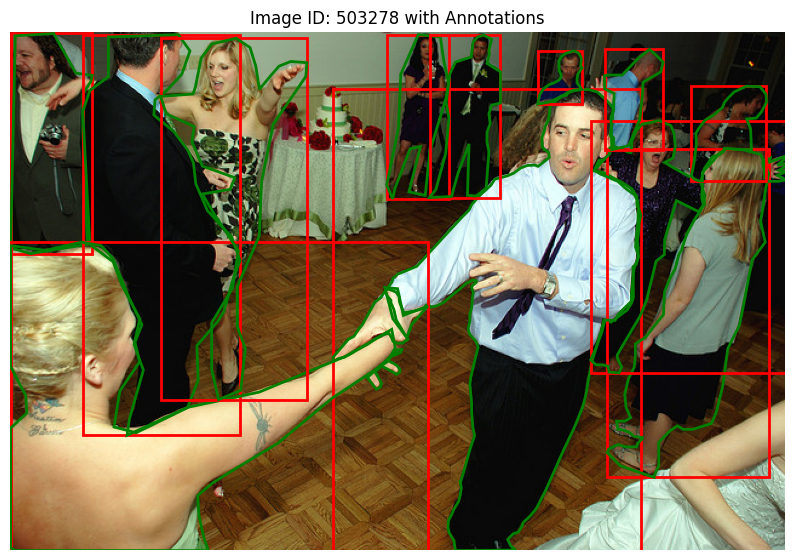

In [ ]:
# Display multiple random samples
for _ in range(3):
    sample_img_id = random.choice(img_ids)
    display_image_with_annotations(coco, sample_img_id, dataset_dir)

In [ ]:
num_annotations = []

for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    num_annotations.append(len(anns))

# Calculate statistics
import statistics

mean_ann = statistics.mean(num_annotations)
median_ann = statistics.median(num_annotations)
max_ann = max(num_annotations)
min_ann = min(num_annotations)

print(f"Average number of persons per image: {mean_ann:.2f}")
print(f"Median number of persons per image: {median_ann}")
print(f"Max number of persons in an image: {max_ann}")
print(f"Min number of persons in an image: {min_ann}")

Average number of persons per image: 4.09
Median number of persons per image: 2
Max number of persons in an image: 20
Min number of persons in an image: 1


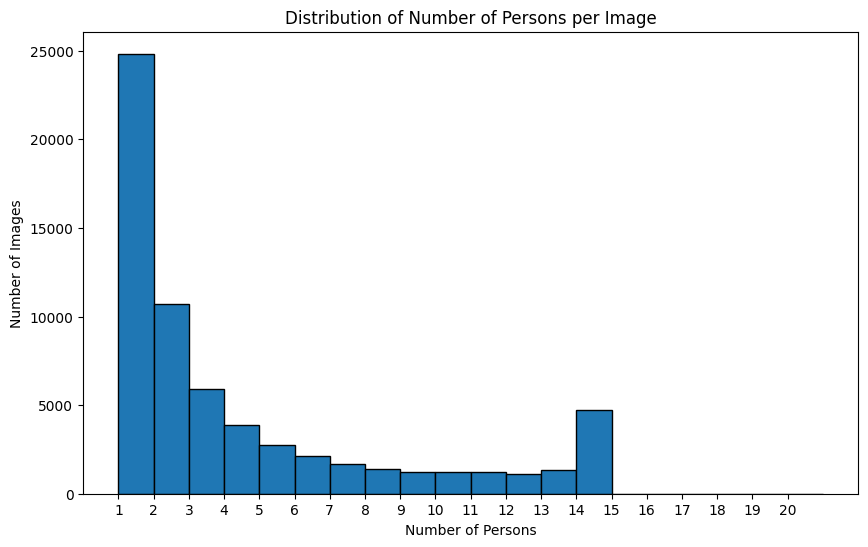

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(num_annotations, bins=range(1, max_ann+2), edgecolor='black')
plt.title("Distribution of Number of Persons per Image")
plt.xlabel("Number of Persons")
plt.ylabel("Number of Images")
plt.xticks(range(1, max_ann + 1))
plt.show()

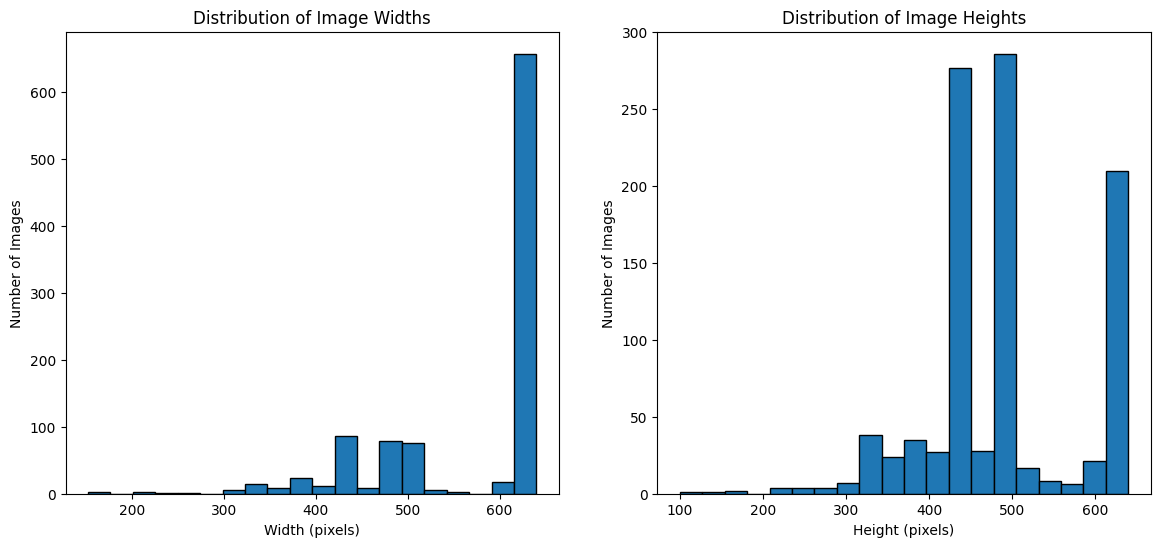

In [ ]:
widths = []
heights = []

for img_id in img_ids[:1000]:  # Limiting to first 1000 images for efficiency
    img_info = coco.loadImgs(img_id)[0]
    widths.append(img_info['width'])
    heights.append(img_info['height'])

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(widths, bins=20, edgecolor='black')
axes[0].set_title('Distribution of Image Widths')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Number of Images')

axes[1].hist(heights, bins=20, edgecolor='black')
axes[1].set_title('Distribution of Image Heights')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Number of Images')

plt.show()

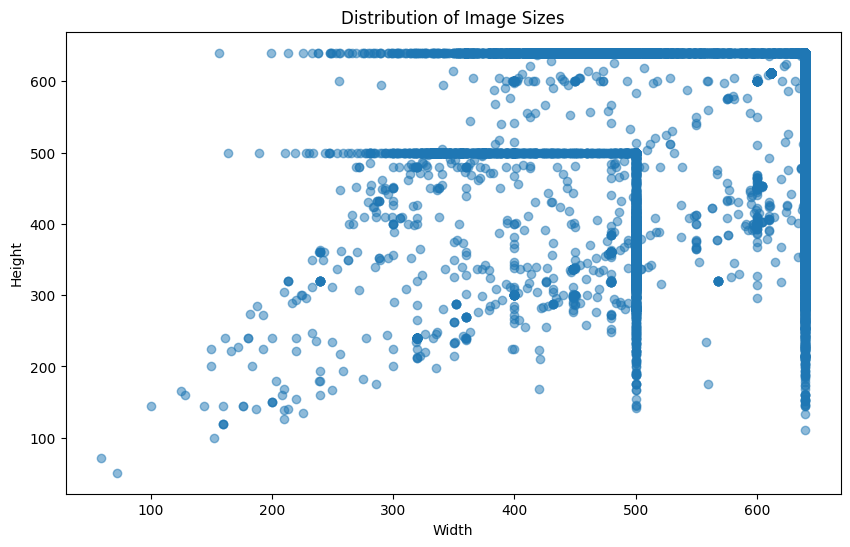

In [ ]:
# Analyze the distribution of image sizes
widths = []
heights = []
for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    widths.append(img_info['width'])
    heights.append(img_info['height'])

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Distribution of Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
def display_image_with_masks(coco, img_id, dataset_dir):
    # Load image metadata
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(dataset_dir, img_info['file_name'])

    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Create mask
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask_ann = coco.annToMask(ann)
        mask = np.maximum(mask, mask_ann * 255)

    # Overlay mask on image
    plt.figure(figsize=(10, 7))
    plt.imshow(img_np)
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"Image ID: {img_id} with Segmentation Masks")
    plt.show()

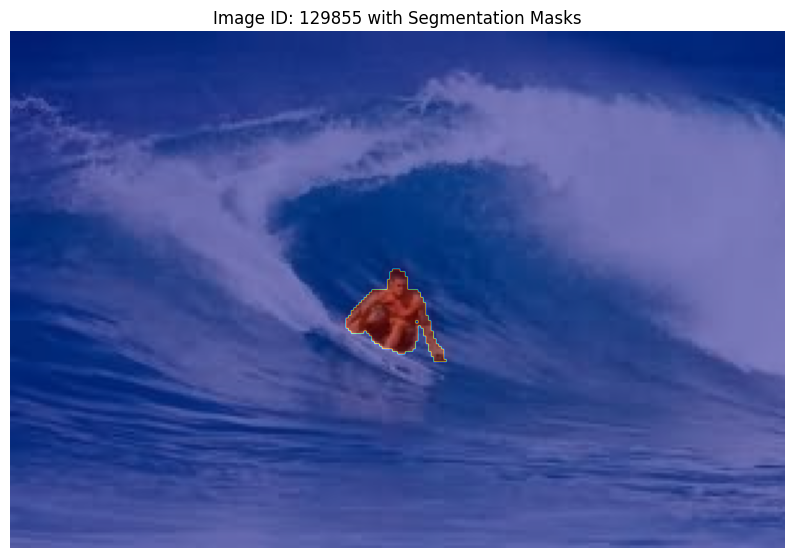

In [ ]:
sample_img_id = random.choice(img_ids)
display_image_with_masks(coco, sample_img_id, dataset_dir)

In [ ]:
missing_images = []

for img_id in img_ids[:1000]:  # Check first 1000 images
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(dataset_dir, img_info['file_name'])
    if not os.path.exists(img_path):
        missing_images.append(img_info['file_name'])

print(f"Number of missing images: {len(missing_images)}")
if missing_images:
    print("Missing images:", missing_images)
else:
    print("All images are accessible.")

Number of missing images: 0
All images are accessible.


Based on our EDA:

- Data Integrity: Images and annotations are properly aligned, and all files are accessible. There are no missing or corrupted files.
- Annotations: The dataset contains a diverse range of images with varying numbers of persons, mostly featuring 1 to 2 persons per image, which aligns well with our project’s focus.
- Image Sizes: There is variability in image dimensions, indicating that we may need to handle resizing or scaling during preprocessing to ensure consistency.
- Segmentation Masks: The segmentation masks accurately represent the persons in the images, confirming that our data loading and processing pipelines are functioning as expected.
- Visualization: Sample images and their annotations look correct, providing visual confirmation that the dataset is correctly prepared for model training.

These findings give us confidence to proceed to the next steps, knowing that our dataset is suitable for training a robust and accurate model.

### Data Preparation

In this section, I prepared my dataset for training by implementing custom transformations and setting up data loaders. I started by creating custom transformation classes to ensure that any augmentations applied to the images are also applied to the corresponding annotations (bounding boxes and masks). This was crucial because standard transformations in PyTorch’s transforms module do not affect the annotations, which can lead to misalignment between images and labels.

To enhance the robustness of my model without affecting the geometry of the images, I included additional transformations like ColorJitter and RandomGrayscale. These augmentations help the model generalize better by simulating variations in lighting and color conditions.

I then implemented a custom COCODataset class that loads images and annotations, applies the transformations, and prepares the data for training. After that, I split the dataset into training, validation and test sets using an 75-12,5-12,5 split to evaluate the model’s performance on unseen data.

To feed data to the model in batches during training, I set up data loaders for all teh sets. Throughout the process, I included verification steps such as printing dataset sizes and visualizing random samples to ensure that the data preparation steps are working correctly and that the images and annotations are properly aligned after transformations.

By taking these steps, I ensured that my dataset is properly prepared and that my data pipeline is robust, setting a solid foundation for training an effective model.

In [ ]:
# 1. Compose Class
class Compose(object):
    """Composes several transforms together."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask

# 2. Resize Class
class Resize(object):
    """Resize the input image to the given size."""
    def __init__(self, size):
        self.size = size  # (height, width)

    def __call__(self, image, mask):
        image = F.resize(image, self.size, interpolation=Image.BILINEAR)
        mask = F.resize(mask, self.size, interpolation=Image.NEAREST)
        return image, mask

# 3. RandomHorizontalFlip Class
class RandomHorizontalFlip(object):
    """Randomly horizontally flips the image, bounding boxes, and masks."""
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, mask):
        if random.random() < self.prob:
            image = F.hflip(image)
            mask = F.hflip(mask)
        return image, mask

# 4. ColorJitterTransform Class
class ColorJitterTransform(object):
    """Applies color jitter to the image."""
    def __init__(self):
        self.color_jitter = transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        )

    def __call__(self, image, mask):
        image = self.color_jitter(image)
        return image, mask

# 5. RandomGrayscaleTransform Class
class RandomGrayscaleTransform(object):
    """Randomly converts the image to grayscale."""
    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, image, mask):
        if random.random() < self.p:
            image = F.rgb_to_grayscale(image, num_output_channels=3)
        return image, mask

# 6. ToTensor Class
class ToTensor(object):
    """Converts PIL Image to Tensor."""
    def __call__(self, image, mask):
        image = F.to_tensor(image)
        mask = torch.as_tensor(np.array(mask), dtype=torch.float32)
        return image, mask

# 7. NormalizeTransform Class
class NormalizeTransform(object):
    """Normalizes the image tensor."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, mask):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, mask

In [ ]:
def get_transform(train=True):
    """Returns a composed transform pipeline."""
    transforms_list = []
    output_size = (480, 640)

    transforms_list += [
        Resize(output_size),
    ]

    if train:
        transforms_list += [
            RandomHorizontalFlip(0.5),
            RandomGrayscaleTransform(0.1),
            ColorJitterTransform(),
        ]

    transforms_list += [
        ToTensor(),
        NormalizeTransform(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
    ]
    return Compose(transforms_list)

In [ ]:
class COCODataset(Dataset):
    def __init__(self, root, annotation, img_ids, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.transforms = transforms
        self.img_ids = img_ids

        # Get category ID for 'person'
        self.cat_ids = self.coco.getCatIds(catNms=['person'])

        # Filter images to include only those with 'person' annotations
        self.img_ids = [
            img_id
            for img_id in self.img_ids
            if len(self.coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids, iscrowd=False)) > 0
        ]

    def __getitem__(self, index):
        # Get image ID
        img_id = self.img_ids[index]

        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Get annotations
        ann_ids = self.coco.getAnnIds(
            imgIds=img_id, catIds=self.cat_ids, iscrowd=False
        )
        anns = self.coco.loadAnns(ann_ids)

        # Extract and combine masks into one binary mask
        masks = []
        for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(torch.as_tensor(mask, dtype=torch.uint8))

        if masks:
            combined_mask = torch.any(torch.stack(masks), dim=0).numpy().astype('uint8')  # Shape: (H, W)
        else:
            # In case there are no masks (shouldn't happen if filtering is correct)
            combined_mask = np.zeros((img.height, img.width), dtype=np.uint8)

        # Convert combined_mask to PIL Image
        combined_mask = Image.fromarray(combined_mask, mode='L')

        # Apply transformations
        if self.transforms:
            img, combined_mask = self.transforms(img, combined_mask)

        return img, combined_mask

    def __len__(self):
        return len(self.img_ids)

In [ ]:
# Get all image IDs containing 'person' category
cat_ids = coco.getCatIds(catNms=['person'])
img_ids = coco.getImgIds(catIds=cat_ids)

# Set a seed for reproducibility
random.seed(42)

# Shuffle the image IDs
random.shuffle(img_ids)

# Define split proportions
train_ratio = 0.75
val_ratio = 0.125
test_ratio = 0.125

# Calculate dataset sizes for each split
total_images = len(img_ids)
train_size = int(train_ratio * total_images)
val_size = int(val_ratio * total_images)
test_size = total_images - train_size - val_size

# Split the image IDs
train_img_ids = img_ids[:train_size]
val_img_ids = img_ids[train_size:train_size + val_size]
test_img_ids = img_ids[train_size + val_size:]

print(f"Number of training images: {len(train_img_ids)}")
print(f"Number of validation images: {len(val_img_ids)}")
print(f"Number of test images: {len(test_img_ids)}")

Number of training images: 48086
Number of validation images: 8014
Number of test images: 8015


In [ ]:
train_dataset = COCODataset(
    root=dataset_dir,
    annotation=annotations_file,
    img_ids=train_img_ids,
    transforms=get_transform(train=True)
)

val_dataset = COCODataset(
    root=dataset_dir,
    annotation=annotations_file,
    img_ids=val_img_ids,
    transforms=get_transform(train=False)
)

test_dataset = COCODataset(
    root=dataset_dir,
    annotation=annotations_file,
    img_ids=test_img_ids,
    transforms=get_transform(train=False)
)

loading annotations into memory...
Done (t=16.76s)
creating index...
index created!
loading annotations into memory...
Done (t=18.49s)
creating index...
index created!
loading annotations into memory...
Done (t=16.47s)
creating index...
index created!


In [ ]:
img, mask = train_dataset[0]
print(f"Image shape: {img.shape}")  # Should be (3, H, W)
print(f"Mask shape: {mask.shape}")   # Should be (H, W)

Image shape: torch.Size([3, 480, 640])
Mask shape: torch.Size([480, 640])


In [ ]:
def collate_fn(batch):
    images, masks = zip(*batch)
    return images, masks


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 1503
Number of validation batches: 251
Number of test batches: 251


In [ ]:
images, masks = next(iter(train_loader))
print(f"Number of images in batch: {len(images)}")  # Should be batch_size
print(f"Image shape: {images[0].shape}")  # Should be (3, H, W)
print(f"Mask shape: {masks[0].shape}")    # Should be (H, W)

Number of images in batch: 32
Image shape: torch.Size([3, 480, 640])
Mask shape: torch.Size([480, 640])


In [ ]:
images = torch.stack(images)  # Shape: (B, 3, H, W)
masks = torch.stack(masks).unsqueeze(1)  # Shape: (B, 1, H, W)

print(f"Stacked image tensor shape: {images.shape}")
print(f"Stacked mask tensor shape: {masks.shape}")

Stacked image tensor shape: torch.Size([32, 3, 480, 640])
Stacked mask tensor shape: torch.Size([32, 1, 480, 640])


In [ ]:
def visualize_sample(img, mask):
    # Convert tensor to numpy array and denormalize
    image = img.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image * std) + mean  # Denormalize
    image = np.clip(image, 0, 1)

    # Convert mask to numpy array
    mask = mask.cpu().numpy()  # Shape: (H, W)

    # Create colored mask
    color = np.array([1.0, 0.0, 1.0])  # Magenta color
    alpha = 0.5  # Transparency

    # Expand mask dimensions to match image channels
    mask_expanded = np.expand_dims(mask, axis=2)  # Shape: (H, W, 1)

    # Blend the mask with the image
    overlay_image = np.where(
        mask_expanded,
        (1 - alpha) * image + alpha * color,
        image
    )

    # Display the image with mask overlaid
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(overlay_image)
    plt.axis('off')
    plt.show()

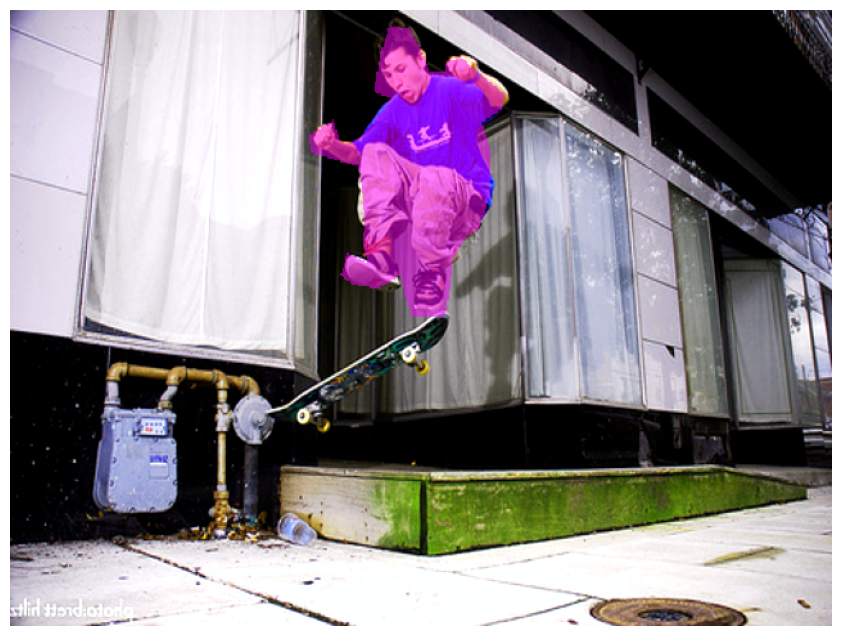

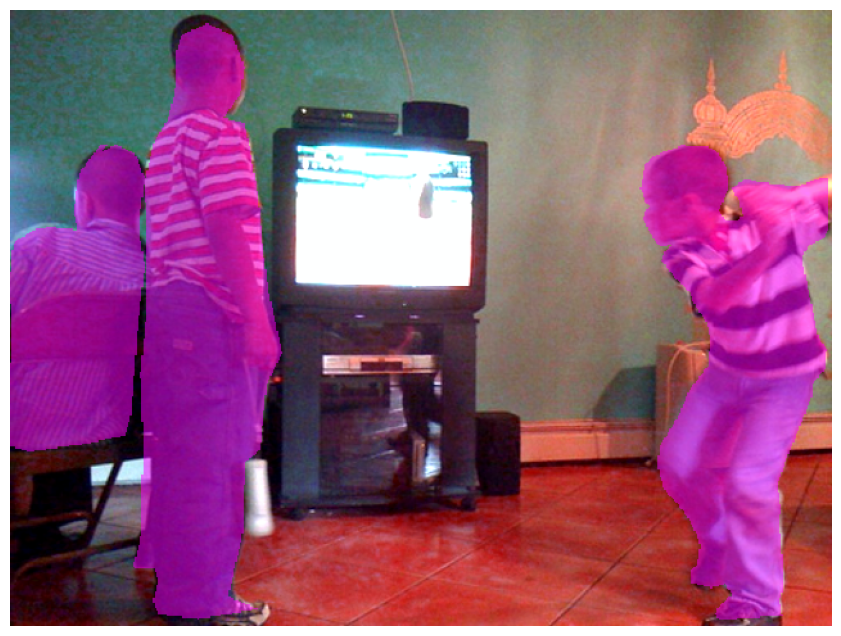

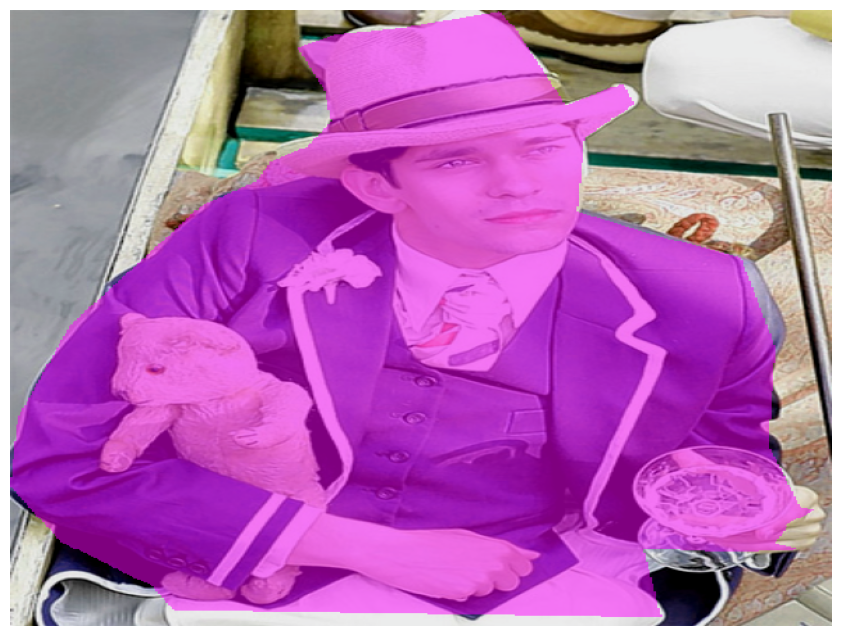

In [ ]:
# Visualize a few samples
for _ in range(3):
    img, mask = random.choice(train_dataset)
    visualize_sample(img, mask)

Shape of the mask: torch.Size([480, 640])


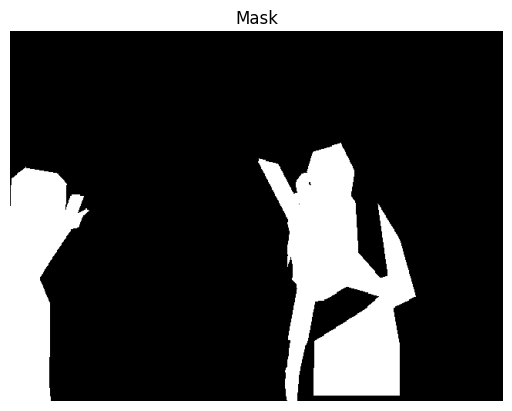

In [ ]:
# Check a sample mask
img, mask = random.choice(train_dataset)
print(f"Shape of the mask: {mask.shape}")
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.title(f"Mask")
plt.axis('off')
plt.show()

### Model Development

Im gonna utilize the U-Net architecture from the segmentation_models_pytorch library, initializing it with a **ResNet-34** encoder pre-trained on ImageNet. This choice balances performance and computational efficiency.
To train our model effectively, I define a combined loss function:

- **Binary Cross-Entropy Loss (BCE):** Measures the binary classification error at each pixel.
- **Dice Loss:** Measures the overlap between the predicted mask and the ground truth, focusing on the segmentation performance.

By combining these losses, we aim to improve both pixel-wise accuracy and the overall shape of the segmented regions.

Then use the **AdamW optimizer** with weight decay for regularization. A Cosine Annealing **LR Scheduler** adjusts the learning rate during training, helping the model converge more effectively.


In [ ]:
# Define the number of classes
num_classes = 1  # For binary segmentation (person vs. background)

# Load the U^2-Net model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
    activation=None
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 317MB/s]


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def loss_fn(outputs, targets):
    outputs = outputs.squeeze(1)  # Shape: (B, H, W)
    targets = targets.squeeze(1)  # Shape: (B, H, W)

    loss1 = bce_loss(outputs, targets)
    loss2 = dice_loss(outputs, targets)
    return loss1 + loss2

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
# Initialize GradScaler only if CUDA is available
if device.type == 'cuda':
    scaler = torch.cuda.amp.GradScaler()
else:
    scaler = None


<ipython-input-40-7098f8a59e76>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


###Training and Evaluation Functions

We define functions for:

- Training One Epoch: Handles the training loop for each epoch, updating model weights.
- Evaluation: Validates the model on the validation set, calculating the loss to monitor performance.
- save the model’s state after each epoch, allowing us to retain the best-performing models for future use or evaluation.

We plot the training and validation losses over epochs to visualize the model’s learning progress. Identifying the epoch with the lowest validation loss helps in selecting the best model.


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), desc=f"Epoch {epoch}", total=len(data_loader), leave=False)
    failed_batches = []

    for batch_idx, (images, masks) in progress_bar:
        images = [image.to(device) for image in images]
        masks = [mask.to(device) for mask in masks]

        images = torch.stack(images)  # Shape: (B, C, H, W)
        masks = torch.stack(masks).unsqueeze(1)  # Shape: (B, 1, H, W)

        optimizer.zero_grad()

        try:
            if device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = loss_fn(outputs, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        except Exception as e:
            # Log the error with epoch and batch information
            print(f"Epoch {epoch}, Batch {batch_idx+1}: Error - {str(e)}")
            failed_batches.append((epoch, batch_idx+1))
            continue  # Skip to the next batch

    epoch_loss = running_loss / len(data_loader.dataset)
    print(f"Epoch [{epoch}] Training Loss: {epoch_loss:.4f}")
    if failed_batches:
        print(f"Failed batches in epoch {epoch}: {failed_batches}")
    return epoch_loss

In [ ]:
def evaluate(model, data_loader, device, epoch):
    model.eval()
    running_loss = 0.0
    failed_batches = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(data_loader), desc=f"Validation Epoch {epoch}", total=len(data_loader), leave=False)
        for batch_idx, (images, masks) in progress_bar:
            images = [image.to(device) for image in images]
            masks = [mask.to(device) for mask in masks]

            images = torch.stack(images)
            masks = torch.stack(masks).unsqueeze(1)

            try:
                if device.type == 'cuda':
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        loss = loss_fn(outputs, masks)
                else:
                    outputs = model(images)
                    loss = loss_fn(outputs, masks)

                running_loss += loss.item() * images.size(0)
                progress_bar.set_postfix(loss=loss.item())

            except Exception as e:
                print(f"Validation Epoch {epoch}, Batch {batch_idx+1}: Error - {str(e)}")
                failed_batches.append((epoch, batch_idx+1))
                continue  # Skip to the next batch

    epoch_loss = running_loss / len(data_loader.dataset)
    print(f"Epoch [{epoch}] Validation Loss: {epoch_loss:.4f}")
    if failed_batches:
        print(f"Failed batches in validation epoch {epoch}: {failed_batches}")
    return epoch_loss

In [ ]:
def save_model(model, optimizer, epoch, scheduler=None, save_dir='/content/drive/MyDrive/deep_learning/models/segmentation'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"U2Net_model_epoch_{epoch}.pth")
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    if scheduler is not None:
        checkpoint['scheduler_state_dict'] = scheduler.state_dict()
    torch.save(checkpoint, model_path)
    print(f"Model saved to {model_path}")

In [ ]:
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training parameters
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    val_loss = evaluate(model, val_loader, device, epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step the scheduler if defined
    if scheduler is not None:
        scheduler.step()

    # Save the model
    save_model(model, optimizer, epoch)

    print(f"Epoch [{epoch}] completed.\n")

Epoch 1:   0%|          | 0/1503 [00:00<?, ?it/s]<ipython-input-41-1ebe15edafd3>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                          

Epoch [1] Training Loss: 0.7134


Validation Epoch 1:   0%|          | 0/251 [00:00<?, ?it/s]<ipython-input-42-f54590f8f7ca>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1] Validation Loss: 0.5058
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_1.pth
Epoch [1] completed.



Epoch [2] Training Loss: 0.4898


Epoch [2] Validation Loss: 0.4240
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_2.pth
Epoch [2] completed.



Epoch [3] Training Loss: 0.4197


Epoch [3] Validation Loss: 0.3697
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_3.pth
Epoch [3] completed.



Epoch [4] Training Loss: 0.3740


Epoch [4] Validation Loss: 0.3368
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_4.pth
Epoch [4] completed.



Epoch [5] Training Loss: 0.3401


Epoch [5] Validation Loss: 0.3079
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_5.pth
Epoch [5] completed.



Epoch [6] Training Loss: 0.3133


Epoch [6] Validation Loss: 0.2951
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_6.pth
Epoch [6] completed.



Epoch [7] Training Loss: 0.2916


Epoch [7] Validation Loss: 0.2750
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_7.pth
Epoch [7] completed.



Epoch 8:  15%|█▍        | 224/1503 [01:40<08:58,  2.37it/s, loss=0.38]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a81dd2e9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a81dd2e9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", 

Epoch [8] Training Loss: 0.2736


Epoch [8] Validation Loss: 0.2651
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_8.pth
Epoch [8] completed.



Epoch [9] Training Loss: 0.2575


Epoch [9] Validation Loss: 0.2549
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_9.pth
Epoch [9] completed.



Epoch [10] Training Loss: 0.2479


Epoch [10] Validation Loss: 0.2542
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_10.pth
Epoch [10] completed.



Epoch [11] Training Loss: 0.2447


Epoch [11] Validation Loss: 0.2542
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_11.pth
Epoch [11] completed.



Epoch [12] Training Loss: 0.2434


Epoch [12] Validation Loss: 0.2480
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_12.pth
Epoch [12] completed.



Epoch [13] Training Loss: 0.2375


Epoch [13] Validation Loss: 0.2385
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_13.pth
Epoch [13] completed.



Epoch [14] Training Loss: 0.2303


Epoch [14] Validation Loss: 0.2318
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_14.pth
Epoch [14] completed.



Epoch [15] Training Loss: 0.2236


Epoch [15] Validation Loss: 0.2323
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_15.pth
Epoch [15] completed.



Epoch [16] Training Loss: 0.2197


Epoch [16] Validation Loss: 0.2229
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_16.pth
Epoch [16] completed.



Epoch [17] Training Loss: 0.2158


Epoch [17] Validation Loss: 0.2226
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_17.pth
Epoch [17] completed.



Epoch [18] Training Loss: 0.2133


Epoch [18] Validation Loss: 0.2227
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_18.pth
Epoch [18] completed.



Epoch [19] Training Loss: 0.2092


Epoch [19] Validation Loss: 0.2296
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_19.pth
Epoch [19] completed.



Epoch [20] Training Loss: 0.2061


Epoch [20] Validation Loss: 0.2229
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_20.pth
Epoch [20] completed.



Epoch [21] Training Loss: 0.1997


Epoch [21] Validation Loss: 0.2284
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_21.pth
Epoch [21] completed.



Epoch [22] Training Loss: 0.1932


Epoch [22] Validation Loss: 0.2225
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_22.pth
Epoch [22] completed.



Epoch [23] Training Loss: 0.1865


Epoch [23] Validation Loss: 0.2178
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_23.pth
Epoch [23] completed.



Epoch [24] Training Loss: 0.1733


Epoch [24] Validation Loss: 0.2086
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_24.pth
Epoch [24] completed.



Epoch [25] Training Loss: 0.1637


Epoch [25] Validation Loss: 0.2085
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_25.pth
Epoch [25] completed.



Epoch [26] Training Loss: 0.1543


Epoch [26] Validation Loss: 0.2039
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_26.pth
Epoch [26] completed.



Epoch [27] Training Loss: 0.1459


Epoch [27] Validation Loss: 0.2017
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_27.pth
Epoch [27] completed.



Epoch [28] Training Loss: 0.1398


Epoch [28] Validation Loss: 0.1994
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_28.pth
Epoch [28] completed.



Epoch [29] Training Loss: 0.1352


Epoch [29] Validation Loss: 0.1993
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_29.pth
Epoch [29] completed.



Epoch [30] Training Loss: 0.1322


Epoch [30] Validation Loss: 0.1981
Model saved to /content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_30.pth
Epoch [30] completed.



In [ ]:
train_losses = [
    0.7133673417217664, 0.4898269410434422, 0.41965570075685565,
    0.37402052416587456, 0.34009121876709353, 0.31333358643659165,
    0.2916258012893191, 0.27363013194230373, 0.2575458240935188,
    0.24786896661722843, 0.24469541633321992, 0.24336032804115806,
    0.23745889313376764, 0.23025571416783183, 0.22355757595020884,
    0.21970510450436023, 0.21582761963948938, 0.21328151280335667,
    0.20922332844296682, 0.20609337922559226, 0.19969150253194634,
    0.19318435200214762, 0.1864559880449258, 0.17328556204072224,
    0.16370805995164256, 0.1543331725342135, 0.14590409911993274,
    0.13981004268425562, 0.13517996667204207, 0.1321901230789414
]

val_losses = [
    0.5057542144151468, 0.42399871387266297, 0.3696666008030235,
    0.33676785489463856, 0.3079426452528666, 0.2950556174883796,
    0.2750453558279327, 0.2650985149320355, 0.25488046301788664,
    0.25417137219627983, 0.25417364608298404, 0.24798073769285103,
    0.23853975490929333, 0.23178502819485755, 0.23225941706661693,
    0.2229402765970085, 0.222573031704117, 0.2226866263871125,
    0.22960165082768724, 0.22294008476361687, 0.22835264871669048,
    0.22246437121693083, 0.21778539081211248, 0.20860567083152298,
    0.20852248947058707, 0.2039067144402251, 0.20168251795254952,
    0.19944001143342216, 0.19925787398791056, 0.1981062328269543
]

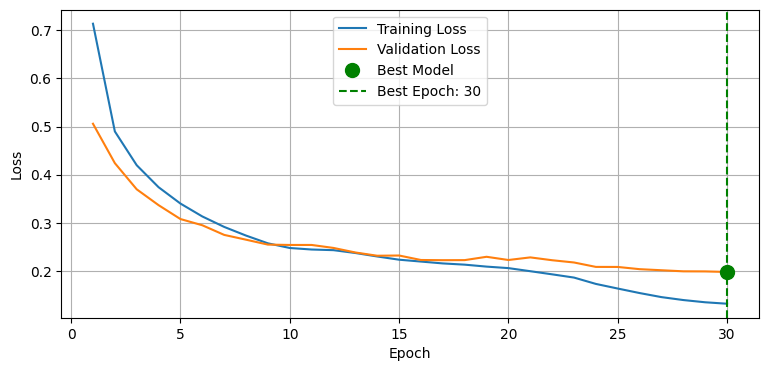

In [ ]:
num_epochs = len(train_losses)
min_val_loss = min(val_losses)
best_epoch = val_losses.index(min_val_loss) + 1

# Plotting the losses
plt.figure(figsize=(9, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(best_epoch, min_val_loss, 'go', markersize=10, label='Best Model')
plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch: {best_epoch}')

# Labels, legend, and grid
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

###Model Evaluation


We load the model corresponding to the epoch with the lowest validation loss for evaluation on the test set.

Evaluate on Test Set

We assess the model’s performance using metrics like:

- Average Dice Coefficient: Measures the overlap between the predicted masks and ground truth.
- Average Intersection over Union (IoU): Evaluates the accuracy of the predicted segmentation regions.
- Average Pixel Accuracy: Computes the percentage of correctly classified pixels.

These metrics provide a comprehensive understanding of the model’s segmentation capabilities.


We finally visualize the model’s predictions on random samples from the test set, comparing the input image, ground truth mask, and the predicted mask. This helps in qualitatively assessing the model’s performance.


In [ ]:
# Define the model architecture (must match the saved model)
num_classes = 1
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,  # Set to None to avoid downloading weights
    in_channels=3,
    classes=num_classes,
    activation=None
)

# Load the saved model state dict
model_path = '/content/drive/MyDrive/deep_learning/models/segmentation/U2Net_model_epoch_30.pth'

# Load the checkpoint
checkpoint = torch.load(model_path, map_location='cuda')
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

<ipython-input-38-a5b4774fb1d0>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cuda')


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    total_dice = 0.0
    total_iou = 0.0
    total_pixels = 0
    total_correct = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]
            masks = [mask.to(device) for mask in masks]

            images_tensor = torch.stack(images)  # Shape: (B, C, H, W)
            masks_tensor = torch.stack(masks).unsqueeze(1)  # Shape: (B, 1, H, W)

            outputs = model(images_tensor)
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).float()

            # Compute Dice coefficient
            intersection = (preds * masks_tensor).sum(dim=(2, 3))
            union = preds.sum(dim=(2, 3)) + masks_tensor.sum(dim=(2, 3))
            dice = (2.0 * intersection) / (union + 1e-7)
            total_dice += dice.sum().item()

            # Compute IoU
            iou = intersection / (union - intersection + 1e-7)
            total_iou += iou.sum().item()

            # Compute pixel accuracy
            total_pixels += masks_tensor.numel()
            total_correct += (preds == masks_tensor).sum().item()

    num_samples = len(data_loader.dataset)
    avg_dice = total_dice / num_samples
    avg_iou = total_iou / num_samples
    avg_pixel_acc = total_correct / total_pixels

    print(f"Average Dice Coefficient: {avg_dice:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Pixel Accuracy: {avg_pixel_acc:.4f}")

    return avg_dice, avg_iou, avg_pixel_acc

In [ ]:
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Evaluate the model on the test set
avg_dice, avg_iou, avg_pixel_acc = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 251/251 [09:58<00:00,  2.38s/it]

Average Dice Coefficient: 0.8083
Average IoU: 0.7286
Average Pixel Accuracy: 0.9702


In [ ]:
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        img, mask = dataset[idx]
        img = img.to(device).unsqueeze(0)  # Add batch dimension
        mask = mask.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

        with torch.no_grad():
            output = model(img)
            output = torch.sigmoid(output)
            pred = (output > 0.5).float()

        img_np = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze(0).squeeze(0).cpu().numpy()
        pred_np = pred.squeeze(0).squeeze(0).cpu().numpy()

        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)

        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img_np)
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        axes[1].imshow(mask_np, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')

        axes[2].imshow(pred_np, cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        plt.show()

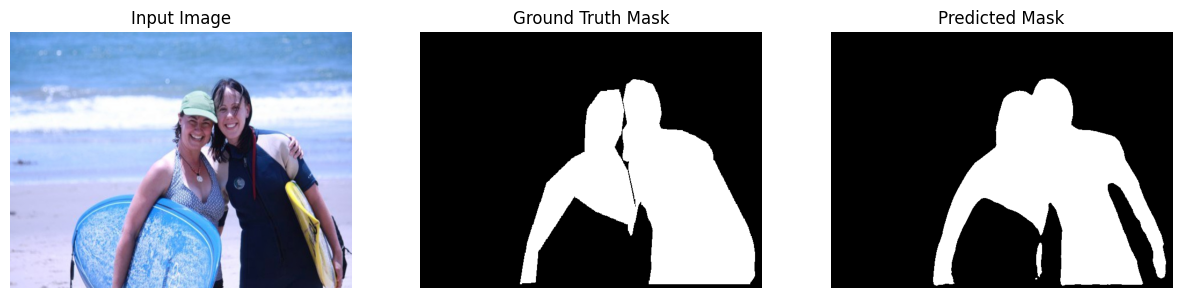

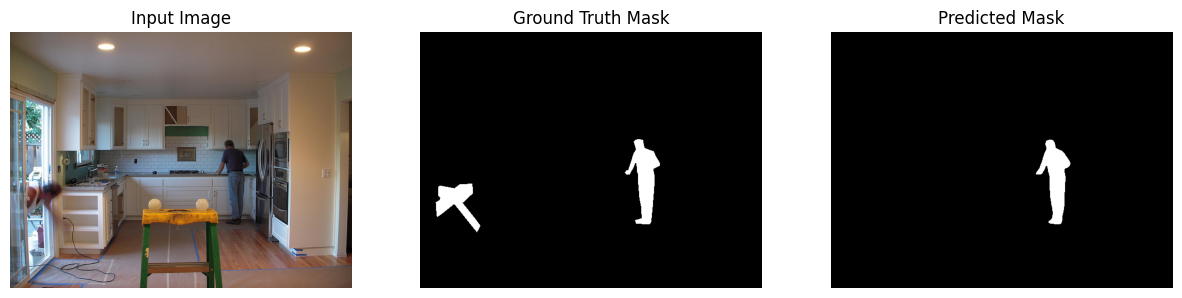

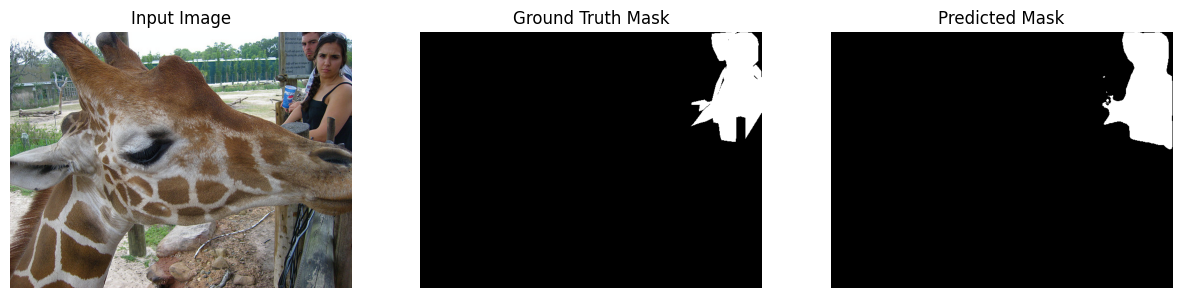

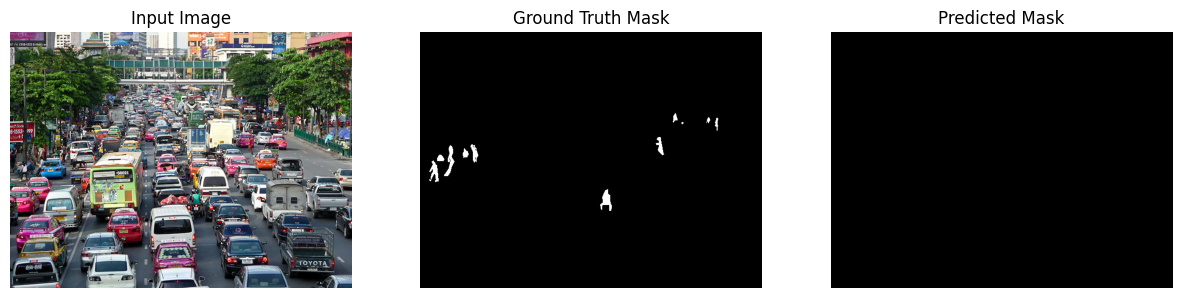

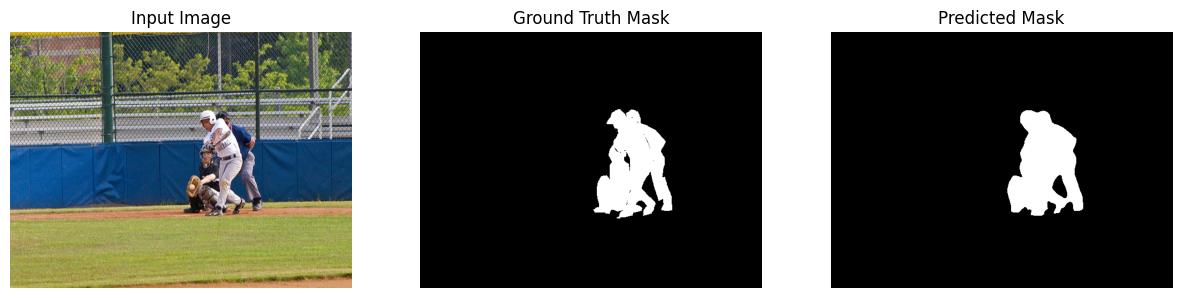

In [ ]:
visualize_predictions(model, test_dataset, device, num_samples=5)

###Post-Processing and Background Replacement


To improve the segmentation masks, we apply morphological operations:

- Closing: Fills small holes in the masks.
- Opening: Removes small objects or noise from the masks.

These operations enhance the quality of the masks before final processing.

Apply Dense CRF for Further Refinement

We utilize Dense Conditional Random Fields (CRF) to further refine the masks by considering the pixel-level relationships and color information from the original image.

Prediction, Refinement, and Visualization Pipeline

We develop a function that:

- Loads and preprocesses an input image.
-	Predicts the segmentation mask using the trained model.
-	Refines the mask using morphological operations and Dense CRF.
-	Replaces the background with a white background or any chosen image.
-	Visualizes the original image, refined mask, and final output.

This pipeline provides an end-to-end solution for segmenting and replacing the background in images.

Testing the Pipeline

We test our complete pipeline on custom images to validate its effectiveness in real-world scenarios. The results demonstrate the model’s ability to accurately segment people and perform seamless background replacement.

In [ ]:
def refine_mask(mask_np, kernel_size=5, min_size=500):
    """
    Refine the binary mask using morphological operations and small object removal.

    Args:
        mask_np (np.ndarray): Binary mask (0 and 1).
        kernel_size (int, optional): Size of the morphological kernel.
        min_size (int, optional): Minimum size of objects to keep.

    Returns:
        np.ndarray: Refined binary mask.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply Closing to fill small holes
    mask_closed = cv2.morphologyEx(mask_np, cv2.MORPH_CLOSE, kernel)

    # Apply Opening to remove small objects
    mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)

    # Remove small objects
    num_labels, labels_im = cv2.connectedComponents(mask_opened)
    mask_filtered = np.zeros_like(mask_opened)

    for label in range(1, num_labels):
        component = (labels_im == label)
        if np.sum(component) > min_size:
            mask_filtered[component] = 1

    return mask_filtered

In [ ]:
# Clone the repository
!git clone https://github.com/lucasb-eyer/pydensecrf.git

# Navigate into the directory
%cd pydensecrf

# Build and install the package
!python setup.py build_ext --inplace
!python setup.py install

Cloning into 'pydensecrf'...
remote: Enumerating objects: 1061, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 1061 (delta 60), reused 351 (delta 51), pack-reused 689 (from 1)
Receiving objects: 100% (1061/1061), 2.68 MiB | 12.69 MiB/s, done.
Resolving deltas: 100% (279/279), done.
/content/pydensecrf
Compiling pydensecrf/eigen.pyx because it changed.
Compiling pydensecrf/densecrf.pyx because it changed.
[1/2] Cythonizing pydensecrf/densecrf.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/pydensecrf/pydensecrf/densecrf.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing pydensecrf/eigen.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' fo

In [ ]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

def apply_dense_crf(image_np, mask_np, num_classes=2, iterations=5):
    """
    Apply Dense CRF to refine the segmentation mask.

    Args:
        image_np (np.ndarray): Original image as a NumPy array in RGB format.
        mask_np (np.ndarray): Binary mask as a NumPy array (0 and 1).
        num_classes (int, optional): Number of classes.
        iterations (int, optional): Number of CRF iterations.

    Returns:
        np.ndarray: Refined binary mask as a NumPy array (0 and 1).
    """
    # Initialize CRF model
    height, width = mask_np.shape
    d = dcrf.DenseCRF2D(width, height, num_classes)

    # Prepare unary potentials
    # Create a softmax-like probability for background and foreground
    epsilon = 1e-6
    mask_probs = np.stack([1 - mask_np, mask_np], axis=0)
    mask_probs = mask_probs + epsilon
    mask_probs = mask_probs / np.sum(mask_probs, axis=0)

    U = unary_from_softmax(mask_probs)
    d.setUnaryEnergy(U)

    # Add pairwise Gaussian potentials
    d.addPairwiseGaussian(sxy=3, compat=3)

    # Add pairwise bilateral potentials
    d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=image_np, compat=10)

    # Run inference
    Q = d.inference(iterations)
    refined_mask = np.argmax(Q, axis=0).reshape((height, width))

    return refined_mask.astype(np.uint8)

In [ ]:
def predict_refine_crf_and_visualize(
    model,
    image_path,
    device,
    preprocess=None,
    mask_threshold=0.5,
    kernel_size=5,
    min_size=500,
    crf_iterations=5,
    output_dir='output',
    show=True,
    save=False
):
    """
    Loads an image, predicts the segmentation mask, refines it using morphological operations and Dense CRF,
    visualizes the result, and optionally saves it.

    Args:
        model (torch.nn.Module): The trained segmentation model.
        image_path (str): Path to the input image.
        device (torch.device): Device to perform computations on.
        preprocess (torchvision.transforms.Compose, optional): Preprocessing transformations.
        mask_threshold (float, optional): Threshold to binarize the predicted masks.
        kernel_size (int, optional): Kernel size for morphological operations.
        min_size (int, optional): Minimum object size to keep in the mask.
        crf_iterations (int, optional): Number of iterations for Dense CRF.
        output_dir (str, optional): Directory to save the output images.
        show (bool, optional): Whether to display the images.
        save (bool, optional): Whether to save the images to disk.
    """
    # Define default preprocessing if not provided
    if preprocess is None:
        preprocess = transforms.Compose([
            transforms.Resize((480, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet means
                                 std=[0.229, 0.224, 0.225])    # ImageNet stds
        ])

    # Load the image
    input_image = Image.open(image_path).convert('RGB')
    original_size = input_image.size  # (width, height)

    if show:
        plt.figure(figsize=(5, 5))
        plt.imshow(input_image)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

    # Apply preprocessing
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Create a mini-batch as expected by the model

    # Run inference
    with torch.no_grad():
        output = model(input_batch)
        output = torch.sigmoid(output)  # Apply sigmoid activation
        output = output.squeeze(0).squeeze(0).cpu().numpy()  # Shape: (H, W)

    # Resize output to original image size
    output = cv2.resize(output, original_size, interpolation=cv2.INTER_LINEAR)

    # Binarize the mask
    binary_mask = (output > mask_threshold).astype(np.uint8)

    # Refine the mask using morphological operations
    refined_mask = refine_mask(binary_mask, kernel_size=kernel_size, min_size=min_size)

    # Apply Dense CRF for further refinement
    image_np = np.array(input_image)
    refined_mask_crf = apply_dense_crf(image_np, refined_mask, num_classes=2, iterations=crf_iterations)

    # Create a white background
    white_background = np.ones_like(image_np) * 255  # White color

    # Apply the refined mask to keep the foreground and set background to white
    mask_np = refined_mask_crf[:, :, np.newaxis]
    foreground = image_np * mask_np
    background = white_background * (1 - mask_np)
    combined_image = foreground + background

    # Convert to PIL Image for visualization or saving
    combined_pil = Image.fromarray(combined_image.astype(np.uint8))

    if show:
        # Display the mask overlay and the final image
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(refined_mask_crf, cmap='gray')
        plt.title('Refined Mask with CRF')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(combined_image)
        plt.title('Image with Background Removed')
        plt.axis('off')

        plt.show()

    if save:
        # Save the combined image
        os.makedirs(output_dir, exist_ok=True)
        base_name = os.path.basename(image_path).split('.')[0]
        output_filename = f"{base_name}_refined.png"
        output_path = os.path.join(output_dir, output_filename)
        combined_pil.save(output_path)
        print(f"Saved: {output_path}")

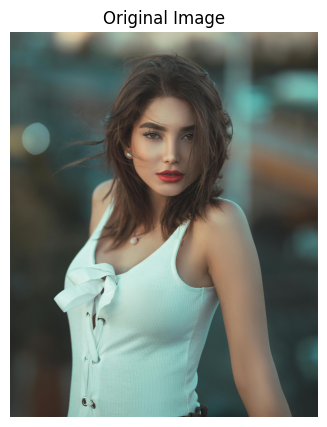

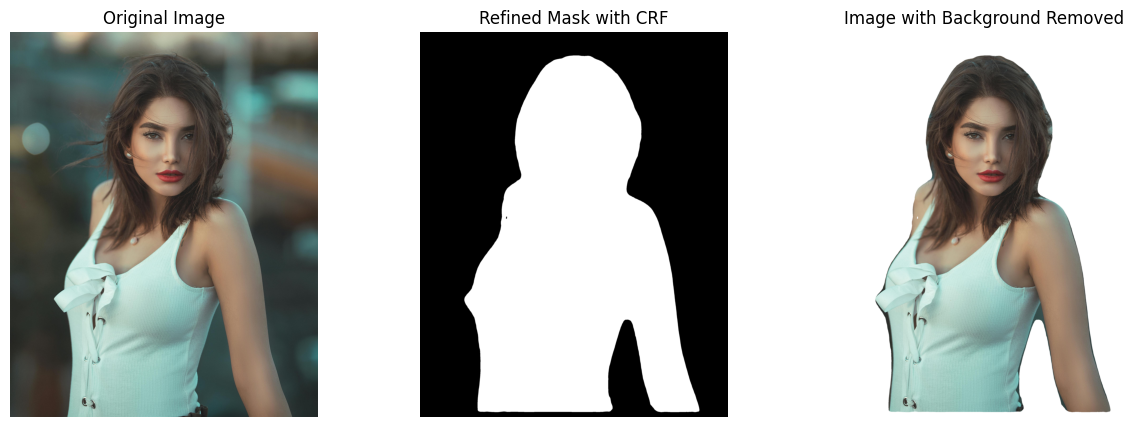

In [ ]:
# Set the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Path to the image you want to evaluate
image_path = '/content/drive/MyDrive/deep_learning/pics_example/bb.jpg'

# Call the function
predict_refine_crf_and_visualize(
    model=model,
    image_path=image_path,
    device=device,
    preprocess=None,
    mask_threshold=0.5,
    kernel_size=5,
    min_size=500,
    crf_iterations=5,
    output_dir='/content/drive/MyDrive/deep_learning/models/segmentation/refined_predictions',
    show=True,
    save=False
)

###Conclusion

In this project, we successfully developed an instance segmentation model using **U^2-Net** and applied it to the COCO dataset focusing on the ‘person’ category. We implemented a comprehensive pipeline that includes data preparation, model training, evaluation, and post-processing steps to refine the segmentation masks. The final pipeline allows for accurate segmentation and seamless background replacement, demonstrating potential applications in photography, virtual backgrounds, and creative media.

Key Takeaways

-	Data Preparation: Proper handling of the dataset and annotations is crucial for training effective models.
-	Model Training: Fine-tuning pre-trained models can yield excellent results with relatively less computational resources.
-	Post-Processing: Techniques like morphological operations and Dense CRF significantly improve segmentation quality.
-	Visualization: Visualizing intermediate results helps in understanding model performance and areas for improvement.

Next Steps

-	Hyperparameter Tuning: Experiment with different architectures and hyperparameters to further improve performance.
-	Real-Time Implementation: Integrate the model into a real-time application or web interface for broader accessibility.
-	Extend to Multiple Classes: Expand the model to handle multiple object categories beyond ‘person’.

Thank you for exploring this project! Feel free to reach out for any questions or collaborations.